In [ ]:
from sstadex import Macromodel, Test, cs_pmos, Primitive, dfs, diffpair_cc, current_mirror_cc, spice_sim, cm_pmos
from sympy import Symbol
from sympy import lambdify

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.colors import LogNorm

import seaborn as sns
sns.set_theme()
sns.color_palette("mako")

sys.path.insert(0, "../../..")
from gmid.mosplot import load_lookup_table, LoadMosfet

# LDO with IHP-SG13G2 low voltage, full cascode (teleescopic OTA)

In [ ]:
## Exploration parameters

N_points = 10
lengths_nmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]
lengths_pmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

## Electrical parameters

Vout = 1.8                                  # LDO output voltage
Vin = 2.2                                    # LDO supply voltage
Vref = 1.2                                      # LDO voltage reference
IL = 5e-3                                     # Load current
CL = 0.5e-12                                    # Load capacitance
RL = Vout/IL

## LDO specifications

efficiency = 0.98
psrr_condition = -70
estability_condition = 60
linereg_condition = 0.5
loadreg_condition = 0.7
#iq_condition = 20e-6
size_condition = 1e-3

I_bias = 5e-6
I_amp1 = 40e-6 # considering the two branches of differential pair
I_amp2 = 20e-6

Iq_max = IL*(1-efficiency)
Ib_pt = Iq_max-I_amp2-I_bias

R1 = (Vout-Vref)/Ib_pt
R2 = Vref*R1/(Vout-Vref)

LDO = pd.DataFrame.from_dict({'Vout': [Vout], 'Vin': [Vin], 'Vref': [Vref], 'IL': [IL], 'CL': [CL], 'RL': [RL], 'Iq_max': [Iq_max], 'Ib_pt': [Ib_pt], 'R1': [R1], 'R2': [R2]}, orient='index', columns=['Value'])
LDO

,Value
Vout,3.300000e+00
Vin,4.000000e+00
Vref,1.800000e+00
IL,5.000000e-03
CL,5.000000e-13
RL,6.600000e+02
Iq_max,1.000000e-04
Ib_pt,7.500000e-05
R1,2.000000e+04
R2,2.400000e+04


# Step-1: Pre-exploration

## Macromodels definition

In [85]:
Vota = np.asarray([3.2, 3.4, 3.7])

In [86]:
## LDO MACROMODEL

LDO_macro = Macromodel(
    name ='LDO_macro', 
    outputs= [
        Symbol("W_pt"), Symbol("L_pt"),
        Symbol("W_cc"), Symbol("L_cc"),
        Symbol("W_rc"), Symbol("L_rc")],
    electrical_parameters={
        "Vdd": Vin, 
        "Vref": Vref, 
        "Vout": Vout, 
        "Vota": Vota,
        "Il": IL+Ib_pt}
    )

## OTA CASCODE DIFFPAIR MACROMODEL

OTA_macro = Macromodel(
    name = 'OTA_macro',
    outputs = [
        Symbol("W_diff_m1"), Symbol("L_diff_m1"),
        Symbol("W_diff_m2"), Symbol("L_diff_m2"),
        Symbol("W_aload_m1"), Symbol("L_aload_m1"),
        Symbol("W_aload_m2"), Symbol("L_aload_m2"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol('vgs_cs')
    ],
    electrical_parameters = {
        "Vdd": LDO_macro.electrical_parameters["Vdd"],
        "Vref": LDO_macro.electrical_parameters["Vref"],
        "Vout": LDO_macro.electrical_parameters["Vota"],
        "Il": I_amp2},
    macromodel_parameters={
        Symbol('Ra'): np.logspace(3, 7, N_points),
        Symbol('gma'): np.logspace(-5, -2, N_points)}
    )

## Testbenches

### LDO

In [87]:
psrr_LDO_macro = Test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [10**(100/20)]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

##############################################################################

dc_LDO_macro = Test()
dc_LDO_macro.name = "dc_LDO"
dc_LDO_macro.tf = ["vout", "vdd"]
dc_LDO_macro.netlist = "ldo"
dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

dc_LDO_macro.opt_goal = "min"
dc_LDO_macro.conditions = {"min": [0]}
dc_LDO_macro.variables = {}
dc_LDO_macro.out_def = {"eval": dc_LDO_macro.tf}
x = Symbol("x")
dc_LDO_macro.lamd = lambdify(x, x*3.3)

##############################################################################

gain_ol_LDO_macro = Test()
gain_ol_LDO_macro.name = "gain_ol_LDO"
gain_ol_LDO_macro.tf = ["vout", "vol"]
gain_ol_LDO_macro.netlist = "ldo_ol"
gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

gain_ol_LDO_macro.opt_goal = "min"
gain_ol_LDO_macro.conditions = {"min": [1]}
gain_ol_LDO_macro.variables = {}
gain_ol_LDO_macro.out_def = {"eval": gain_ol_LDO_macro.tf}

##############################################################################

phase_margin_LDO_macro = Test()
phase_margin_LDO_macro.name = "phase_margin_LDO"
phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.opt_goal = "min"
phase_margin_LDO_macro.conditions = {"min": [-300]}
phase_margin_LDO_macro.variables = {}
phase_margin_LDO_macro.out_def = {"pm": phase_margin_LDO_macro.tf}

### OTA

In [88]:
gain_OTA = Test()
gain_OTA.tf = ("vout", "vpos")
gain_OTA.name = "gain_OTA"
gain_OTA.netlist = "ota_1stage"
gain_OTA.parametros = {
    Symbol("gaload_2"): Symbol("gaload_1"),
    Symbol("Raload_2"): Symbol("Raload_1"),
    Symbol("gdiff_2"): Symbol("gdiff_1"), 
    Symbol("Rdiff_2"): Symbol("Rdiff_1"),
    Symbol("V1"): 0,
    Symbol("V_b"): 0,
    Symbol("V_n"): 0,
    Symbol("V_p"): 1,
    Symbol("I2"): 0,
    Symbol("s"): 0,
    Symbol("Cl"): 1e-1}

gain_OTA.opt_goal = "max"
gain_OTA.conditions = {"min": [10**(-100/20)]}
gain_OTA.variables = {}
gain_OTA.out_def = {"eval": gain_OTA.tf}

#########################################################

phase_margin_OTA = Test()
phase_margin_OTA.name = "phase_margin_OTA"
phase_margin_OTA.tf = ["vout", "vpos"]
phase_margin_OTA.netlist = "OpAmp_2stage"
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): 1e-12}

phase_margin_OTA.opt_goal = "min"
phase_margin_OTA.conditions = {"min": [0]}
phase_margin_OTA.variables = {}
phase_margin_OTA.out_def = {"pm": phase_margin_OTA.tf}

##########################################################

rout_OTA = Test()
rout_OTA.name = "rout_OTA"
rout_OTA.target_param = Symbol("Ra")
rout_OTA.tf = ["vout", "vr"]
rout_OTA.netlist = "ota_1stage_rout"
rout_OTA.parametros = {Symbol("gdiff_2"): Symbol("gdiff_1"),
                              Symbol("Rdiff_2"): Symbol("Rdiff_1"),
                                Symbol("gaload_2"): Symbol("gaload_1"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("V1"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cl"): 1e-12}

rout_OTA.opt_goal = "max"
rout_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_OTA.variables = {}
rout_OTA.out_def = {"eval": rout_OTA.tf}

##########################################################

gm_OTA = Test()
gm_OTA.target_param = Symbol("gma")
gm_OTA.name = "gm_OTA"
gm_OTA.tf = ["vout", "vpos"]
gm_OTA.netlist = "ota_1stage"
gm_OTA.composed = 1
gm_OTA.out_def = {"divide": [gain_OTA, rout_OTA]}
gm_OTA.opt_goal = "max"
gm_OTA.conditions = {"min": [0.000000001]}

## Primitives definition

### LDO primitives

In [89]:
pt = cs_pmos(
    lut_file="../../LUTs/IHP_LUT_hv_20w.npy",
    lut_w=20e-6,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-3.3, -0.1, 0.01), 
        'vgs': LDO_macro.electrical_parameters["Vota"]-Vin, 
        'il': LDO_macro.electrical_parameters["Il"],
        'length': lengths_pmos, 
        '2d_var': ['length', 'vgs']})

pt_df = pt.build()

mask = (pt_df["width"]>5e-6) & (pt_df["width"]<15e-3)

pt_df = pt_df[mask]

pt.parameters = {
    Symbol('gm_pt'): pt_df['gm'].values,
    Symbol('Ro_pt'): pt_df['Ro'].values,
    Symbol("Cgg_pt"): pt_df['cgg'].values,
    Symbol("Cgd_pt"): pt_df['cgd'].values,
    Symbol("Cin_pt"): pt_df['cgg'].values+pt_df["cgd"].values*pt_df["gm"].values*pt_df["Ro"].values,
    Symbol("dropout"): 2/(pt_df["gm"].values/pt.inputs['il']),
    Symbol('Vota'): np.tile(LDO_macro.electrical_parameters["Vota"], 5)[mask]}

pt.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

# CASE 2: WITHOUT LOAD

## found operation point of the circuit with no load
lookup_table = load_lookup_table('../../LUTs/IHP_LUT_hv_20w.npy')

pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='pmos',
            vsb=0,
            vds=LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"],
            vgs=(-3.3, -0.1, 0.01),
            lengths=lengths_pmos,
        )

jd_2 = Ib_pt/pt.W.flatten()

vgs_2 = pt_lutable.interpolate(
            x_expression=pt_lutable.current_density_expression,
            x_value=jd_2,
            y_expression=pt_lutable.lengths_expression,
            y_value=pt.L.flatten(),
            z_expression=pt_lutable.vgs_expression,
        )

vgs_2 = np.diag(vgs_2)
print("Values of Vgs_pt when there is no load: ", vgs_2)
##

vout_2stage_wc = vgs_2

pt_wc = cs_pmos(
    lut_file="../../LUTs/IHP_LUT_hv_20w.npy",
    lut_w=20e-6,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-3.3, -0.1, 0.01), 
        'vgs': vout_2stage_wc, 
        'il': Ib_pt,
        'length': pt.L.flatten(), 
        '2d_var': ['length', 'vgs']})

pt_wc_df = pt_wc.build()

pt_wc.parameters = {
    Symbol('gm_pt'): pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol('Ro_pt'): pt_wc_df["Ro"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("Cgg_pt"): pt_wc_df["cgg"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("Cgd_pt"): pt_wc_df["cgd"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("dropout"): 2/(pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]/pt_wc.inputs['il']),
    Symbol("Cin_pt"): pt_wc_df["cgg"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]
                        +pt_wc_df["cgd"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]
                        *pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]*pt_wc_df["Ro"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol('Vota'): Vin+vout_2stage_wc[mask]}

pt_wc.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

length
vgs
0
Values of Vgs_pt when there is no load:  [-0.51915982 -0.42166883 -0.11220212 -0.54402614 -0.42654323 -0.10303497
 -0.55256113 -0.42778838 -0.10091648 -0.55573296 -0.42822054 -0.10048457
 -0.55694132 -0.42767544 -0.10031343]
length
vgs
0


In [90]:
2/pt.parameters[Symbol("dropout")]

array([8.22235349, 9.43871302])

In [91]:
pt.parameters[Symbol("dropout")]

array([0.24323936, 0.21189329])

In [92]:
pt.parameters[Symbol("Vota")]

array([3.2, 3.2])

In [76]:
pt.W

array([[8.95468641e-05, 1.25153895e-04, 2.47751888e-04],
       [2.07911114e-04, 2.96939452e-04, 6.10394556e-04],
       [4.48618860e-04, 6.46644589e-04, 1.35141957e-03],
       [9.37082264e-04, 1.35704296e-03, 2.86132060e-03],
       [1.91764102e-03, 2.78368364e-03, 5.89573010e-03]])

### OTA primitives

In [93]:
sweep_size_dp = 3
vin_dp = OTA_macro.electrical_parameters["Vref"]
vout_dp = OTA_macro.electrical_parameters["Vout"]
vs_dp = np.linspace(0.1, vin_dp-0.1, sweep_size_dp)
vcp_dp = np.linspace(vin_dp, vout_dp-0.1, sweep_size_dp)

diffpair_primitive = diffpair_cc(
    vcp_dp, 
    vs_dp, 
    vin_dp, 
    vout_dp, 
    I_amp2/2, 
    sweep_size_dp, 
    lengths_nmos, 
    vout_dp + 0.5,
    "../../LUTs/IHP_LUT_hv_20w.npy",
    20e-6)

diffpair_primitive_df =  diffpair_primitive.build()

diffpair_primitive_mask = (diffpair_primitive_df["width_m1"]>1e-6) & (diffpair_primitive_df["width_m2"]>1e-6) & (diffpair_primitive_df["width_m1"]<2e-4) & (diffpair_primitive_df["width_m2"]<2e-4)

diffpair_primitive_df = diffpair_primitive_df[diffpair_primitive_mask]

diffpair_primitive.parameters = {Symbol("Rdiff_1"): diffpair_primitive_df["Ro"].values, 
                                 Symbol("gdiff_1"): diffpair_primitive_df["gm"].values,
                                 Symbol("vbias"): diffpair_primitive_df["vbias"].values,
                                 Symbol("vs_diff"): diffpair_primitive_df["vs"].values}
diffpair_primitive.outputs = {Symbol("W_diff_m1"): diffpair_primitive_df["width_m1"].values,
                              Symbol("W_diff_m2"): diffpair_primitive_df["width_m2"].values,
                              Symbol("L_diff_m1"): diffpair_primitive_df["length_m1"].values,
                              Symbol("L_diff_m2"): diffpair_primitive_df["length_m2"].values}

## OTA stage1 active load ################################################################

vout_cm = 1.122 - Vin
sweep_size_cm = 5

vcp_cm = np.linspace(vout_cm+0.1, -0.1, sweep_size_cm)

print("vout_cm: ", vout_cm)
print("vcp_cm: ", vcp_cm)

activeload_primmitive = current_mirror_cc(
    vcp_cm, 
    vout_cm, 
    I_amp2/2, 
    sweep_size_cm, 
    lengths_nmos, 
    vout_cm - 0.5,
    "../../LUTs/IHP_LUT_hv_20w.npy",
    20e-6)

activeload_primitive_df = activeload_primmitive.build()

activeload_primitive_mask = (activeload_primitive_df["width_m1"]>1e-6) & (activeload_primitive_df["width_m2"]>1e-6) & (activeload_primitive_df["width_m1"]<2e-4) & (activeload_primitive_df["width_m2"]<2e-4)
activeload_primitive_df = activeload_primitive_df[activeload_primitive_mask]

activeload_primmitive.parameters = {Symbol("Raload_1"): activeload_primitive_df["Ro"].values,
                                    Symbol("gaload_1"): activeload_primitive_df["gm"].values,
                                    Symbol("vbias_cm"): activeload_primitive_df["vbias"].values}
activeload_primmitive.outputs = {Symbol("W_aload_m1"): activeload_primitive_df["width_m1"].values,
                                 Symbol("L_aload_m1"): activeload_primitive_df["length_m1"].values,
                                 Symbol("W_aload_m2"): activeload_primitive_df["width_m2"].values,
                                 Symbol("L_aload_m2"): activeload_primitive_df["length_m2"].values}

vds
vgs
1
M1 jd:  [[1.76311304e+02 1.65123002e+01 6.08249885e-07 1.76311304e+02
  1.65123002e+01 6.08249885e-07 1.76311304e+02 1.65123002e+01
  6.08249885e-07]
 [8.10472551e+01 4.93441464e+00 5.76879734e-08 8.10472551e+01
  4.93441464e+00 5.76879734e-08 8.10472551e+01 4.93441464e+00
  5.76879734e-08]
 [4.08031989e+01 2.71247089e+00 9.84013468e-08 4.08031989e+01
  2.71247089e+00 9.84013468e-08 4.08031989e+01 2.71247089e+00
  9.84013468e-08]
 [2.04156046e+01 1.45435561e+00 1.00439538e-07 2.04156046e+01
  1.45435561e+00 1.00439538e-07 2.04156046e+01 1.45435561e+00
  1.00439538e-07]
 [1.01971571e+01 7.53175569e-01 7.25296697e-08 1.01971571e+01
  7.53175569e-01 7.25296697e-08 1.01971571e+01 7.53175569e-01
  7.25296697e-08]]
M1 gmid:  [[ 1.36055185  6.25582087 25.30420007  1.36055185  6.25582087 25.30420007
   1.36055185  6.25582087 25.30420007]
 [ 1.76907515  7.03184884 27.22257732  1.76907515  7.03184884 27.22257732
   1.76907515  7.03184884 27.22257732]
 [ 1.86976699  6.44338764 27.018865

ValueError: operands could not be broadcast together with shapes (1215,) (405,) 

In [ ]:
#############################################################################

currentsource = cm_pmos()
currentsource.parameters = {
    Symbol('gcs'): [],
    Symbol('Rcs'): [],
    Symbol('vs_cs'): [],
    Symbol('vgs_cs'): []}
currentsource.outputs = {
    Symbol("W_cs"): [],
    Symbol("L_cs"): []}

for vds_cs in vs_dp:

    vgs_cs = np.linspace(vds_cs-0.2, vds_cs+0.6, 5)

    currentsource_aux = cm_pmos(
        lut_file="../../LUTs/ihp_lut_hv_20w.npy",
        lut_w=20e-6,
        netlist='pmos_cs.spice',
        type='nmos',
        inputs={
            'vds_lut': vds_cs, 
            'vgs_lut': (0.1, 3.3, 0.01), 
            'vgs': vgs_cs, 
            'il': I_amp2,
            'length': lengths_nmos, 
            '2d_var': ['length', 'vgs']})
    currentsource_aux.build()

    currentsource.parameters[Symbol('gcs')].append(np.asarray(currentsource_aux.gm).flatten())
    currentsource.parameters[Symbol('Rcs')].append(np.asarray(currentsource_aux.Ro).flatten())
    currentsource.parameters[Symbol('vs_cs')].append(np.asarray(np.repeat(vds_cs, len(lengths_nmos)*len(vgs_cs))).flatten())
    currentsource.parameters[Symbol('vgs_cs')].append(np.asarray(np.tile(vgs_cs, len(lengths_nmos))).flatten())
    currentsource.outputs[Symbol('W_cs')].append(np.asarray(currentsource_aux.W).flatten())
    currentsource.outputs[Symbol('L_cs')].append(np.asarray(currentsource_aux.L).flatten())


currentsource.parameters[Symbol('gcs')] = np.asarray(currentsource.parameters[Symbol('gcs')]).flatten()
currentsource.parameters[Symbol('Rcs')] = np.asarray(currentsource.parameters[Symbol('Rcs')]).flatten()
currentsource.parameters[Symbol('vs_cs')] = np.asarray(currentsource.parameters[Symbol('vs_cs')]).flatten()
currentsource.parameters[Symbol('vgs_cs')] = np.asarray(currentsource.parameters[Symbol('vgs_cs')]).flatten()
currentsource.outputs[Symbol('W_cs')] = np.asarray(currentsource.outputs[Symbol('W_cs')]).flatten()
currentsource.outputs[Symbol('L_cs')] = np.asarray(currentsource.outputs[Symbol('L_cs')]).flatten()
currentsource.outputs[Symbol('vgs_cs')] = currentsource.parameters[Symbol('vgs_cs')]

length
vgs
0
length
vgs
0
length
vgs
0


In [ ]:
1.8+vout_2stage_wc

In [ ]:
vout_2stage_wc = vout_2stage_wc[0]

In [ ]:
diffpair_primitive_wc = diffpair_cc(
    vcp_dp, 
    vs_dp, 
    vin_dp, 
    1.8-vout_2stage_wc, 
    I_amp2/2, 
    sweep_size_dp, 
    lengths_nmos, 
    vout_dp + 0.5,
    "../../LUTs/IHP_LUT_lv_10w.npy",
    10e-6)
diffpair_primitive_wc.build()      

diffpair_primitive_wc.parameters = {Symbol("Rdif_1"): np.asarray(diffpair_primitive_wc.Ro).flatten(), 
                                 Symbol("gdif_1"): np.asarray(diffpair_primitive_wc.gm).flatten(),
                                 Symbol("vbias"): np.asarray(diffpair_primitive_wc.vbias).flatten()}
diffpair_primitive_wc.outputs = {Symbol("W_diff_m1"): np.asarray(diffpair_primitive.W_m1).flatten(),
                              Symbol("W_diff_m2"): np.asarray(diffpair_primitive.W_m2).flatten(),
                              Symbol("L_diff_m1"): np.asarray(diffpair_primitive.L_m1).flatten(),
                              Symbol("L_diff_m2"): np.asarray(diffpair_primitive.L_m2).flatten()}



## OTA stage1 active load ################################################################

activeload_primmitive_wc = current_mirror_cc(
    vcp_cm, 
    vout_2stage_wc, 
    I_amp2/2, 
    sweep_size_cm, 
    lengths_nmos, 
    vout_cm - 0.5,
    "../../LUTs/IHP_LUT_lv_10w.npy",
    10e-6)
activeload_primmitive_wc.build()

activeload_primmitive_wc.parameters = {Symbol("Raload_1"): np.asarray(activeload_primmitive_wc.Ro).flatten(),
                                    Symbol("gaload"): np.asarray(activeload_primmitive_wc.gm).flatten(),
                                    Symbol("vbias_cm"): np.asarray(activeload_primmitive_wc.vbias).flatten()}
activeload_primmitive_wc.outputs = {Symbol("W_aload_m1"): np.asarray(activeload_primmitive.W_m1).flatten(),
                                 Symbol("L_aload_m1"): np.asarray(activeload_primmitive.L_m1).flatten(),
                                 Symbol("W_aload_m2"): np.asarray(activeload_primmitive.W_m2).flatten(),
                                 Symbol("L_aload_m2"): np.asarray(activeload_primmitive.L_m2).flatten()}

# Step-3: Results propagation

In [ ]:
len(activeload_primitive_df)*len(diffpair_primitive_df)*75

197925

In [ ]:
len(diffpair_primitive_df)

91

In [25]:
OTA_macro.ext_mask = None

OTA_macro.primitives = [diffpair_primitive, activeload_primmitive, currentsource]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df, _ = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  ota_1stage
Netlist:  ota_1stage
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[('vout', 'vpos')]
Netlist:  ota_1stage_rout
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss  vr
0     1   2     3     4     5    6    0   7
[['vout', 'vr']]
Netlist:  ota_1stage
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(-2*Raload_1**2*Rcs*Rdiff_1**2*gaload_1*gdiff_1**2 - 2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1**2*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1*gdiff_1 - Raload_1*Rcs*Rdiff_1**2*gdiff_1**2 - Raload_1*Rcs*Rdiff_1*gdiff_1 - Raload_1*Rdiff_1**2*gdiff_1)/(2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 + 2*Raload_1**2*Rcs*gaload_1 + Raload_1**2*Rdiff_1*gaload_1 + Raload_1**2 + 2*Raload_1*Rcs*Rdiff_1**2*gaload_1*gdif

In [26]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])

In [29]:
ota_df_new = ota_df[ota_df[Symbol("W_cs")]<2e-4]

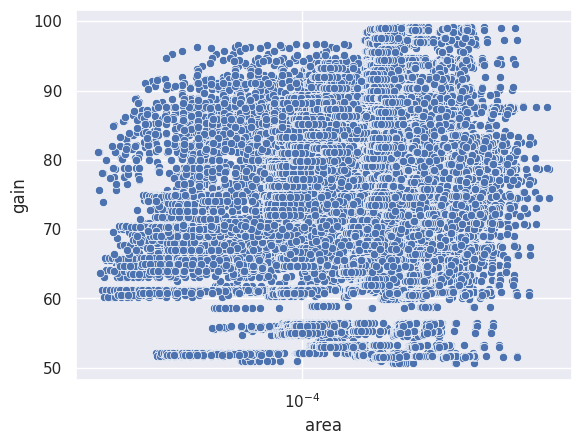

In [31]:
sns.scatterplot(data=ota_df_new, x="area", y="gain")
plt.xscale("log")

In [47]:
pt.parameters[Symbol("dropout")]

0     1.076174
1     0.950786
2     0.720282
3     0.513997
4     1.011994
5     0.898425
6     0.682000
7     0.480032
8     0.986660
9     0.877393
10    0.666381
11    0.466854
12    0.974359
13    0.866815
14    0.658466
15    0.460781
16    0.968237
17    0.861539
18    0.654639
19    0.458071
Name: gm, dtype: float64